In [5]:
import numpy as np
import pandas as pd
import sys
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
data_frame = pd.read_csv('../ANN_part2/mnist_train.csv', delimiter=',')
data = data_frame.to_numpy()

labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(60000,)
(60000, 784)


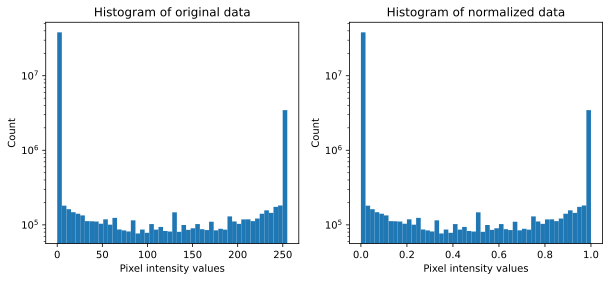

In [3]:
# normalize data to a range of [0, 1]
data_norm = data / np.max(data)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(data_norm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

In [4]:
dataT = torch.tensor(data_norm).float()

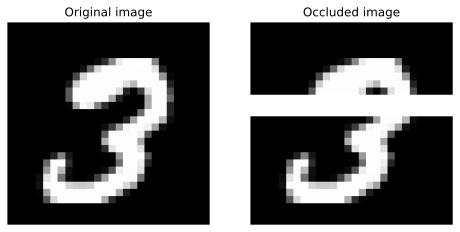

In [6]:
img = dataT[12345, :].view(28, 28)
occluded = copy.deepcopy(img)
occluded[10:13, :] = 1

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(occluded, cmap='gray')
ax[1].set_title('Occluded image')
ax[1].axis('off')

plt.show()

In [7]:
def create_model():
    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784,128)
            
            self.enc = nn.Linear(128, 50)
            
            self.lat = nn.Linear(50, 128)
            
            self.dec = nn.Linear(128, 784)
            
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            
            y = torch.sigmoid(self.dec(x))
            
            return y
        
    model = MnistNet()
    
    loss_fun = nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    
    return model, loss_fun, optimizer

In [12]:
num_of_epochs = 5
batch_size = 32

def train_model():
    model, loss_func, optimizer = create_model()
    
    losses = []
    
    rows_idxs = np.arange(dataT.shape[0])
    np.random.shuffle(rows_idxs)
    
    num_of_batches = len(rows_idxs) // batch_size
    
    for epoch in range(num_of_epochs):
        for batch_idx in range(num_of_batches):
        
            randomidx = rows_idxs[batch_idx*batch_size:batch_idx*batch_size+batch_size]
            X = dataT[randomidx, :]
                
            yHat = model(X)
            loss = loss_func(yHat, X)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            losses.append(loss.item())
        
    return losses, model

Final loss: 0.0077


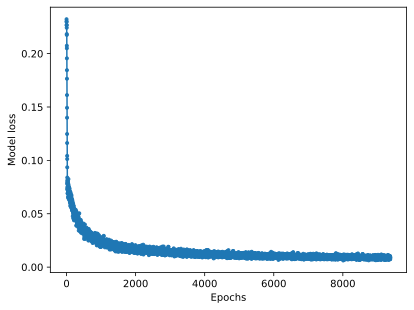

In [13]:
losses, model = train_model()
print(f"Final loss: {losses[-1]:.4f}")

plt.plot(losses, '.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

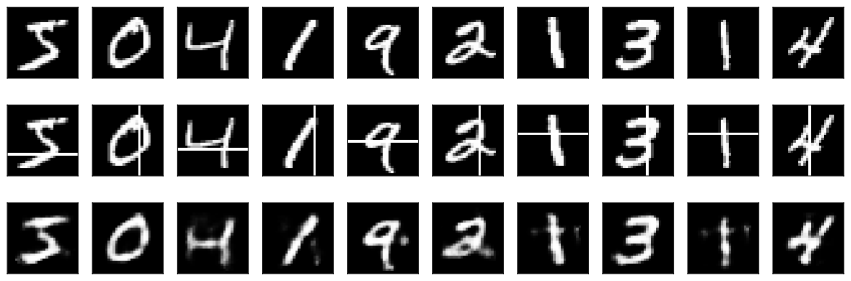

In [14]:
X = copy.deepcopy(dataT[:10, :])

for i in range(X.shape[0]):
    img = X[i, :].view(28, 28)
    
    start_loc = np.random.choice(range(10, 21))
    if i%2==0:
        img[start_loc:start_loc+1, :] = 1
    else:
        img[:, start_loc:start_loc+1] = 1
        
deoccluded = model(X)

fig, axs = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    axs[0, i].imshow(dataT[i, :].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(X[i, :].view(28, 28).detach(), cmap='gray')
    axs[2, i].imshow(deoccluded[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[2, i].set_yticks([])
    
plt.show()

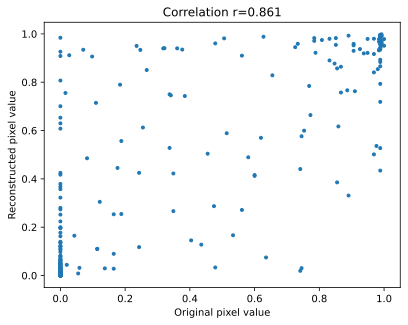

In [15]:
in_out_corr = np.corrcoef(dataT[9, :].detach(), deoccluded[9, :].detach())

plt.plot(dataT[9, :].detach(), deoccluded[9, :].detach(), '.')
plt.xlabel('Original pixel value')
plt.ylabel('Reconstructed pixel value')
plt.title(f"Correlation r={in_out_corr[0,1]:.3f}")
plt.show()

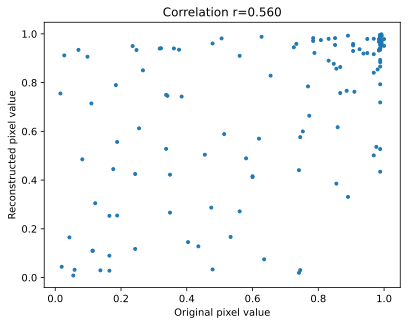

In [16]:
orig = dataT[9, :].detach()
recon = deoccluded[9, :].detach()

tol = 1e-4
non_zero_pixels = (orig>tol) & (recon>tol)

in_out_corr = np.corrcoef(orig[non_zero_pixels], recon[non_zero_pixels])

plt.plot(orig[non_zero_pixels], recon[non_zero_pixels], '.')
plt.xlabel('Original pixel value')
plt.ylabel('Reconstructed pixel value')
plt.title(f"Correlation r={in_out_corr[0,1]:.3f}")
plt.show()

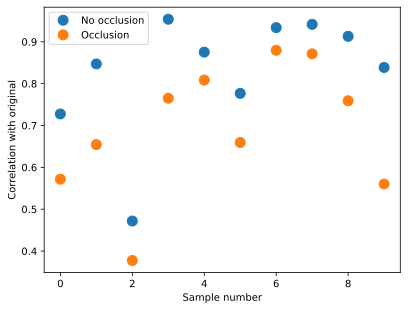

In [21]:
no_occlusion = model(dataT[:10, :])

r = np.zeros((10, 2))

for i in range(deoccluded.shape[0]):
    non_zero_pixels = (dataT[i, :]>tol) & (no_occlusion[i, :]>tol) & (deoccluded[i, :]>tol)
    r[i,0] = np.corrcoef(dataT[i, non_zero_pixels].detach(), no_occlusion[i, non_zero_pixels].detach())[0,1]
    r[i,1] = np.corrcoef(dataT[i, non_zero_pixels].detach(), deoccluded[i, non_zero_pixels].detach())[0,1]
    
plt.plot(r, 'o', markersize='10')
plt.legend(['No occlusion', 'Occlusion'])
plt.xlabel('Sample number')
plt.ylabel('Correlation with original')
plt.show()